## BANA 8090 Final Project- Movies' Ratings Prediction

In this project, we will be performing: 
- Web scraping on IMDb website to get data from 10000 movies
- Merge the data from IMDb website with a dataset from Kaggle 
- Exploratory Data Analysis to summarize variables that will be used to predict movies' ratings
- Modeling using: Linear Regression, Regression Tree, Random Forest, Neural Network
- The MSE of each model will be calculated to compare models and choose one

### Importing the packages needed

In [1]:
import lxml
import re
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from requests import get
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.tree import DecisionTreeRegressor

Using TensorFlow backend.


### Web Scraping

In [2]:
#creating the list of urls
url1=[]

pages= np.arange(1,10000,249)
for i in pages:
    url1.append("https://www.imdb.com/search/title/?title_type=feature,tv_series&count=249&start=" + str(i)+"&ref_=adv_nxt") 

#creating web scraping function
class IMDB(object):
	"""docstring for IMDB"""
	def __init__(self, url):
		super(IMDB, self).__init__()
		page = get(url)

		self.soup = BeautifulSoup(page.content, 'lxml')

	def articleTitle(self):
		return self.soup.find("h1", class_="header").text.replace("\n","")

	def bodyContent(self):
		content = self.soup.find(id="main")
		return content.find_all("div", class_="lister-item mode-advanced")

	def movieData(self):
		movieFrame = self.bodyContent()
		movieTitle = []
		movieDate = []
		movieRunTime = []
		movieGenre = []
		movieRating = []
		movieScore = []
		movieDescription = []
		movieDirector = []
		movieStars = []
		movieVotes = []
		movieGross = []
		movieMetascore1 = []
		movieMetascore2 = []
		movieMetascore3 = []
		for movie in movieFrame:
			movieFirstLine = movie.find("h3", class_="lister-item-header")
			movieTitle.append(movieFirstLine.find("a").text)
			movieDate.append(re.sub(r"[()]","", movieFirstLine.find_all("span")[-1].text))
			try:
				movieRunTime.append(movie.find("span", class_="runtime").text[:-4])
			except:
				movieRunTime.append(np.nan)
#			movieGenre.append(movie.find("span", class_="genre").text.rstrip().replace("\n","").split(","))
			try:
				movieRating.append(movie.find("strong").text)
			except:
				movieRating.append(np.nan)
			try:
				movieScore.append(movie.find("span", class_="metascore unfavorable" ).text.rstrip())
			except:
				movieScore.append(np.nan)
			movieDescription.append(movie.find_all("p", class_="text-muted")[-1].text.lstrip())
			movieCast = movie.find("p", class_="")

			try:
				casts = movieCast.text.replace("\n","").split('|')
				casts = [x.strip() for x in casts]
				casts = [casts[i].replace(j, "") for i,j in enumerate(["Director:", "Stars:"])]
				movieDirector.append(casts[0])
				movieStars.append([x.strip() for x in casts[1].split(",")])
			except:
				casts = movieCast.text.replace("\n","").strip()
				movieDirector.append(np.nan)
				movieStars.append([x.strip() for x in casts.split(",")])

			movieNumbers = movie.find_all("span", attrs={"name": "nv"})

			if len(movieNumbers) == 2:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(movieNumbers[1].text)
			elif len(movieNumbers) == 1:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(np.nan)
			else:
				movieVotes.append(np.nan)
				movieGross.append(np.nan)

			movieNumbers2 = movie.find_all("span", class_="metascore unfavorable")

			if len(movieNumbers2) == 1:
				movieMetascore1.append(movieNumbers2[0].text)
			else:
				movieMetascore1.append(np.nan)

			movieNumbers3 = movie.find_all("span", class_="metascore favorable")

			if len(movieNumbers3) == 1:
				movieMetascore2.append(movieNumbers3[0].text)
			else:
				movieMetascore2.append(np.nan)
                
                
			movieNumbers4 = movie.find_all("span", class_="metascore mixed")

			if len(movieNumbers4) == 1:
				movieMetascore3.append(movieNumbers4[0].text)
			else:
				movieMetascore3.append(np.nan)


		movieData = [movieTitle, movieDate, movieRunTime,  movieRating, movieScore, movieDescription,
							movieDirector, movieStars, movieVotes, movieGross, movieMetascore1, movieMetascore2, movieMetascore3]
		return movieData
    
#Applying IMDB function on lists of urls and storing data
data = []
for i in range(40):
    if __name__ == '__main__':
        site1=IMDB(url1[i])
        print("Subject: ", site1.articleTitle())
        data.append(site1.movieData())
#	for i in range(len(data)):
#		print(data[i][:])

Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  

### Data pre-processing

In [3]:
#Appending data from 40 urls
for i in range(len(data)):
    data[i]=pd.DataFrame(data[i]).transpose()
    
df=data[0].append([data[1],data[2],data[3],data[4],data[5],
data[6],data[7],data[8],data[9],data[10],data[11],data[12],data[13],data[14],data[15],data[16],data[17],data[18],data[19],data[20],
data[21],data[22],data[23],data[24],data[25],data[26],data[27],data[28],data[29],
data[30],data[31],data[32],data[33],data[34],data[35],data[36],data[37],data[38],data[39]])

In [4]:
#Renaming the year column
df_new = df.rename(columns={1: 'year'})
df_new.head()

,0,year,2,3,4,5,6,7,8,9,10,11,12
0,Money Heist,2017–,70,8.5,NaN,An unusual group of robbers attempt to carry o...,NaN,"[Stars:Úrsula Corberó, Álvaro Morte, Itziar It...","221,510",NaN,NaN,NaN,NaN
1,Ozark,2017–,60,8.4,NaN,A financial advisor drags his family from Chic...,NaN,"[Stars:Jason Bateman, Laura Linney, Sofia Hubl...","139,878",NaN,NaN,NaN,NaN
2,Onward,I 2020,102,7.5,NaN,Two elven brothers embark on a quest to bring ...,Dan Scanlon,"[Tom Holland, Chris Pratt, Julia Louis-Dreyfus...","44,530",NaN,NaN,61,NaN
3,Westworld,2016–,62,8.7,NaN,Set at the intersection of the near future and...,NaN,"[Stars:Evan Rachel Wood, Jeffrey Wright, Ed Ha...","389,863",NaN,NaN,NaN,NaN
4,The Walking Dead,2010–,44,8.2,NaN,Sheriff Deputy Rick Grimes wakes up from a com...,NaN,"[Stars:Andrew Lincoln, Norman Reedus, Melissa ...","822,583",NaN,NaN,NaN,NaN


In [5]:
#Creating a column for metascore 
df_new['meta']=np.nan

In [6]:
#Assigning value to metascore column
for i in range(len(df_new)):
    if (pd.notnull(df_new.iloc[i,10])):
        df_new.iloc[i,13]=df_new.iloc[i,10]
    elif (pd.notnull(df_new.iloc[i,11])):
        df_new.iloc[i,13]=df_new.iloc[i,11]
    else: 
        df_new.iloc[i,13]=df_new.iloc[i,12]

In [7]:
df_new.head()

,0,year,2,3,4,5,6,7,8,9,10,11,12,meta
0,Money Heist,2017–,70,8.5,NaN,An unusual group of robbers attempt to carry o...,NaN,"[Stars:Úrsula Corberó, Álvaro Morte, Itziar It...","221,510",NaN,NaN,NaN,NaN,NaN
1,Ozark,2017–,60,8.4,NaN,A financial advisor drags his family from Chic...,NaN,"[Stars:Jason Bateman, Laura Linney, Sofia Hubl...","139,878",NaN,NaN,NaN,NaN,NaN
2,Onward,I 2020,102,7.5,NaN,Two elven brothers embark on a quest to bring ...,Dan Scanlon,"[Tom Holland, Chris Pratt, Julia Louis-Dreyfus...","44,530",NaN,NaN,61,NaN,61
3,Westworld,2016–,62,8.7,NaN,Set at the intersection of the near future and...,NaN,"[Stars:Evan Rachel Wood, Jeffrey Wright, Ed Ha...","389,863",NaN,NaN,NaN,NaN,NaN
4,The Walking Dead,2010–,44,8.2,NaN,Sheriff Deputy Rick Grimes wakes up from a com...,NaN,"[Stars:Andrew Lincoln, Norman Reedus, Melissa ...","822,583",NaN,NaN,NaN,NaN,NaN


In [8]:
#Dropping metascore columns 
movies_df=df_new.drop(columns=[4,10,11,12],axis=1)

In [9]:
#Renaming columns
movies_df.columns = ['title','year','duration','rating','description','director','actors','votes','budget','metascore']

In [10]:
#Subsetting the data to movies subset
movies = movies_df[~movies_df['year'].str.contains('–')]
movies.head()

,title,year,duration,rating,description,director,actors,votes,budget,metascore
2,Onward,I 2020,102,7.5,Two elven brothers embark on a quest to bring ...,Dan Scanlon,"[Tom Holland, Chris Pratt, Julia Louis-Dreyfus...","44,530",NaN,61
5,The Platform,2019,94,7.0,A vertical prison with one cell per level. Two...,Galder Gaztelu-Urrutia,"[Ivan Massagué, Zorion Eguileor, Antonia San J...","93,198",NaN,73
7,Trolls World Tour,2020,90,6.1,Poppy and Branch discover that they are but on...,"Directors:Walt Dohrn, David P. Smith","[Anna Kendrick, Justin Timberlake, Rachel Bloo...","4,454",NaN,51
9,The Gentlemen,2019,113,8.0,An American expat tries to sell off his highly...,Guy Ritchie,"[Matthew McConaughey, Charlie Hunnam, Michelle...","106,834",NaN,51
12,Extraction,2020,116,NaN,"Tyler Rake, a fearless black market mercenary,...",Sam Hargrave,"[Chris Hemsworth, Golshifteh Farahani, David H...",NaN,NaN,NaN


In [11]:
#Getting last 4 numbers of year
for i in range(len(movies)):
        movies.iloc[i,1]=movies.iloc[i,1][-4:] 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
#Importing second dataset
movies_kaggle=pd.read_csv('movies_metadata.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
movies_kaggle.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [14]:
movies_kaggle.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,FALSE,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,FALSE,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,FALSE,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,FALSE,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,FALSE,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [15]:
# Dropping columns that will not be used
movies_kaggle=movies_kaggle.drop(columns=['belongs_to_collection','budget','homepage','id','imdb_id',
                            'original_title', 'overview', 'runtime',
                            'spoken_languages', 'status', 'tagline', 'video',
                            'vote_average', 'vote_count'],axis=1);

In [16]:
# Removing duplicates from the title column
movies_kaggle=movies_kaggle.drop_duplicates(subset="title",keep=False)

In [17]:
#Getting last 4 numbers of year
for i in range(len(movies_kaggle)):
    if (pd.notnull(movies_kaggle.iloc[i,7])):
        movies_kaggle.iloc[i,7]=movies_kaggle.iloc[i,7][0:4] 

In [18]:
#Joining the two datasets
movies_ratings=pd.merge(movies,movies_kaggle,left_on=['title','year'],right_on=['title','release_date'])

In [19]:
len(movies_ratings)

4293

In [20]:
movies_ratings.columns

Index(['title', 'year', 'duration', 'rating', 'description', 'director',
       'actors', 'votes', 'budget', 'metascore', 'adult', 'genres',
       'original_language', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue'],
      dtype='object')

In [21]:
movies_ratings=movies_ratings.drop(columns='release_date',axis=1)

In [22]:
#Checking for null values
movies_ratings.isnull().sum()

title                     0
year                      0
duration                  0
rating                    0
description               0
director                  2
actors                    0
votes                     0
budget                  567
metascore               571
adult                     0
genres                    0
original_language         0
popularity                0
poster_path               1
production_companies      0
production_countries      0
revenue                   0
dtype: int64

In [23]:
movies_ratings["duration"] = movies_ratings["duration"].astype(str).astype(float)
movies_ratings["rating"] = movies_ratings["rating"].astype(str).astype(float)
#movies_ratings["votes"] = movies_ratings["votes"].astype(str).astype(float)
#movies_ratings["budget"] = movies_ratings["budget"].astype(str)
movies_ratings["metascore"] = movies_ratings["metascore"].astype(str).astype(float)
movies_ratings["popularity"] = movies_ratings["popularity"].astype(str).astype(float)
movies_ratings["revenue"] = movies_ratings["revenue"].astype(str).astype(float)

In [24]:
# Cleaning the budget column
for i in range(len(movies_ratings)):
    if (pd.notnull(movies_ratings.iloc[i,8])):
     movies_ratings.iloc[i,8]=movies_ratings.iloc[i,8].strip('$').strip('M')

In [25]:
movies_ratings["budget"] = movies_ratings["budget"].astype(str).astype(float)

In [26]:
movies_ratings['budget']=movies_ratings['budget']*1000000

In [27]:
movies_ratings["title"] = movies_ratings["title"].astype('str')
movies_ratings["year"] = movies_ratings["year"].astype('str').astype('category')
movies_ratings["director"] = movies_ratings["director"].astype('str').astype('category')
movies_ratings["adult"] = movies_ratings["adult"].astype('str').astype('category')
movies_ratings["original_language"] = movies_ratings["original_language"].astype('str').astype('category')

In [28]:
# Dropping null values
movies_ratings=movies_ratings.dropna(how='any',axis=0) 

### Exploratory Data Analysis

In [29]:
movies_ratings.describe()

,duration,rating,budget,metascore,popularity,revenue
count,3469.000000,3469.000000,3.469000e+03,3469.000000,3469.000000,3.469000e+03
mean,110.510233,6.675036,5.330610e+07,57.652061,11.380052,1.071770e+08
std,20.135719,0.938826,6.812151e+07,18.192447,14.702833,1.781178e+08
min,63.000000,1.900000,0.000000e+00,1.000000,0.090273,0.000000e+00
25%,96.000000,6.100000,1.006000e+07,45.000000,7.041967,7.500000e+06
50%,107.000000,6.700000,3.177000e+07,58.000000,9.475693,4.210511e+07
75%,120.000000,7.300000,6.924000e+07,71.000000,12.608530,1.262169e+08
max,366.000000,9.300000,7.605100e+08,100.000000,547.488298,2.787965e+09


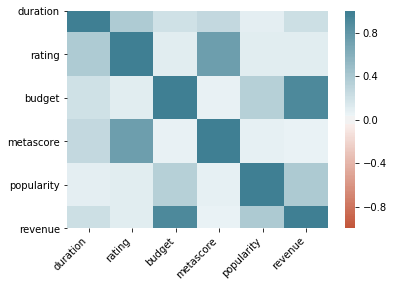

In [30]:
#Correlation matrix

corr = movies_ratings.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
);
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Boxplots of variables

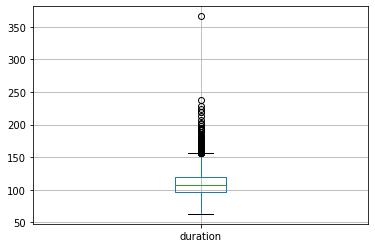

In [31]:
movies_ratings.boxplot(column=['duration'])

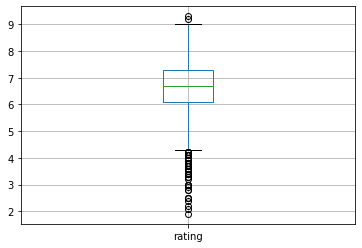

In [32]:
movies_ratings.boxplot(column=['rating'])

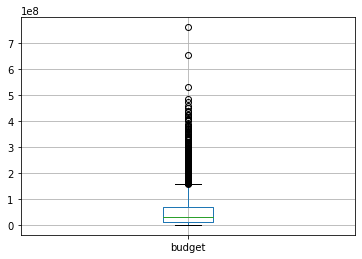

In [33]:
movies_ratings.boxplot(column=['budget'])

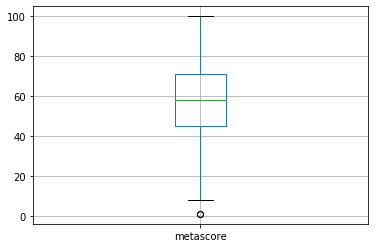

In [34]:
movies_ratings.boxplot(column=['metascore'])

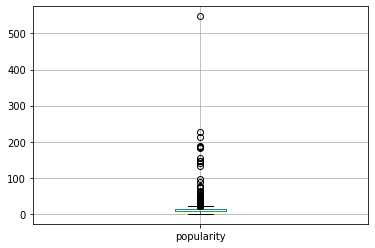

In [35]:
movies_ratings.boxplot(column=['popularity'])

In [36]:
# We will remove the outlier popularity observation from the dataset
movies_ratings = movies_ratings[movies_ratings.popularity < 300]

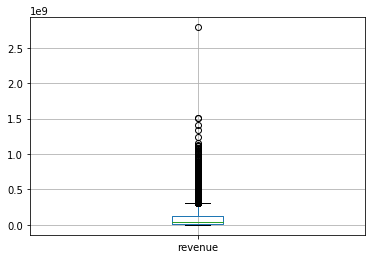

In [37]:
movies_ratings.boxplot(column=['revenue'])

Plots

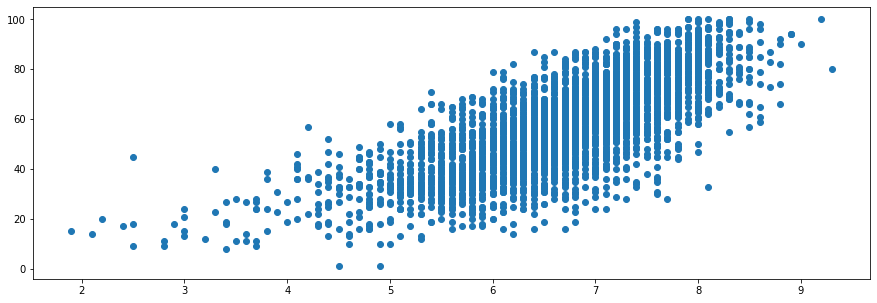

In [38]:
#Ratings vs Metascore
fig, ax=plt.subplots(1, figsize=(15,5))
ax.scatter('rating','metascore',data=movies_ratings)

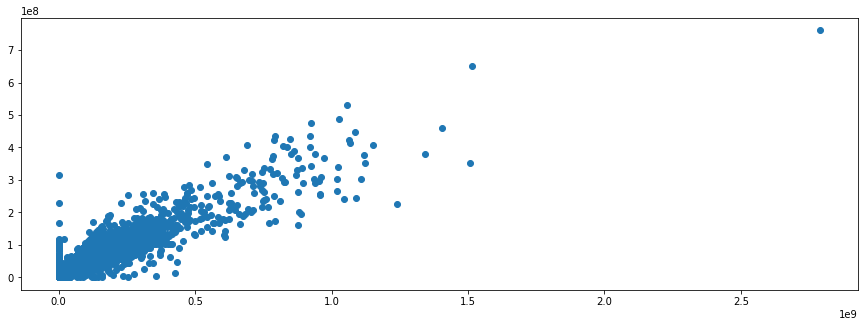

In [39]:
#Revenue vs Budget
fig, ax=plt.subplots(1, figsize=(15,5))
ax.scatter('revenue','budget',data=movies_ratings)

Text(0.5, 1.0, 'Distribution of Ratings')

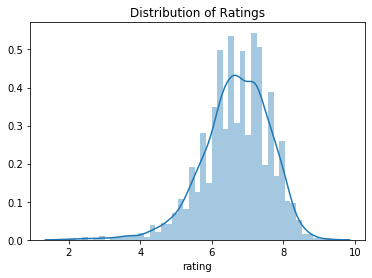

In [40]:
#Distribution of Ratings
sns.distplot(movies_ratings['rating']).set_title('Distribution of Ratings')

Text(0.5, 1.0, 'Distribution of metascore')

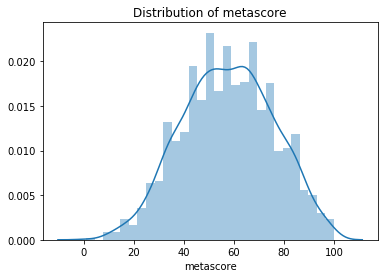

In [41]:
#Distribution of Metascore
sns.distplot(movies_ratings['metascore']).set_title('Distribution of metascore')

Text(0.5, 1.0, 'Distribution of Duration')

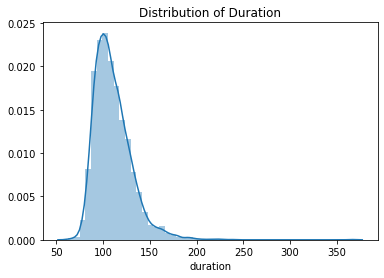

In [42]:
#Distribution of Duration
sns.distplot(movies_ratings['duration']).set_title('Distribution of Duration')

Text(0.5, 1.0, 'Distribution of budget')

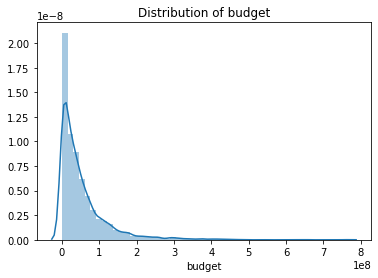

In [43]:
# Distribution of Budget
sns.distplot(movies_ratings['budget']).set_title('Distribution of budget')

Text(0.5, 1.0, 'Distribution of revenue')

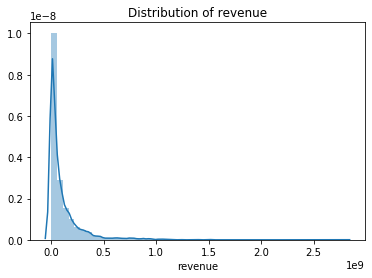

In [44]:
# Distribution of Revenue
sns.distplot(movies_ratings['revenue']).set_title('Distribution of revenue')

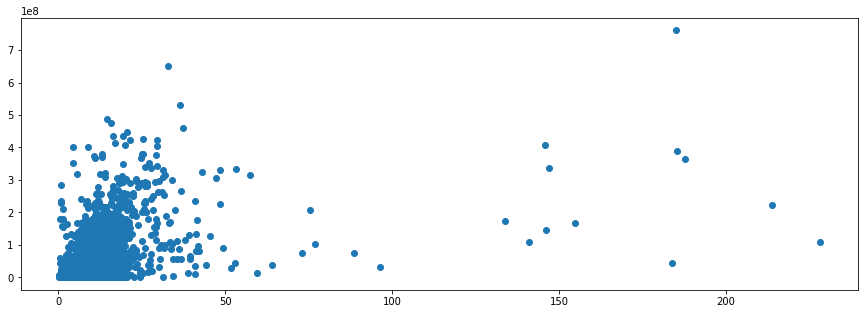

In [45]:
# Scatter plot of popularity and budget
fig, ax=plt.subplots(1, figsize=(15,5))
ax.scatter('popularity','budget',data=movies_ratings)

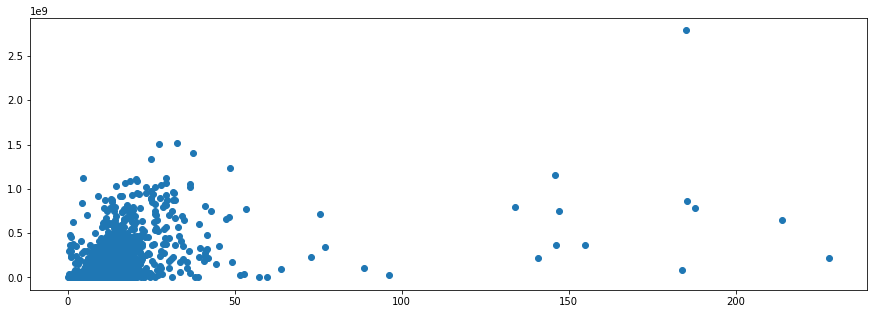

In [46]:
# Scatter plot of popularity and revenue
fig, ax=plt.subplots(1, figsize=(15,5))
ax.scatter('popularity','revenue',data=movies_ratings)

<BarContainer object of 32 artists>

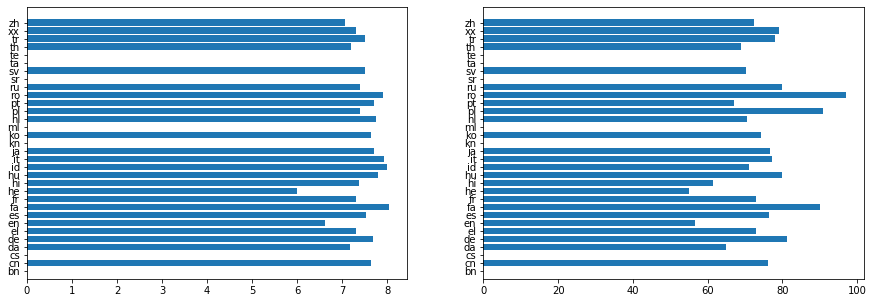

In [47]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].barh('original_language','rating',data=movies_ratings.groupby('original_language',as_index=False).mean())
ax[1].barh('original_language','metascore',data=movies_ratings.groupby('original_language',as_index=False).mean())

In [48]:
movies_ratings.groupby('year',as_index=False).mean()

,year,duration,rating,budget,metascore,popularity,revenue
0,1920,NaN,NaN,NaN,NaN,NaN,NaN
1,1922,NaN,NaN,NaN,NaN,NaN,NaN
2,1925,NaN,NaN,NaN,NaN,NaN,NaN
3,1928,NaN,NaN,NaN,NaN,NaN,NaN
4,1931,87.000000,8.500000,2.000000e+04,99.000000,10.891524,1.918100e+04
...,...,...,...,...,...,...,...
86,2014,110.244604,6.674101,5.687489e+07,56.474820,18.114108,1.456569e+08
87,2015,111.379845,6.519380,5.293550e+07,56.193798,13.534978,1.353585e+08
88,2016,110.047337,6.587574,5.240231e+07,58.579882,15.433255,1.341463e+08
89,2017,110.712121,6.389394,6.424136e+07,56.984848,31.455768,1.509032e+08


In [49]:
movies_ratings.groupby('original_language',as_index=False).mean()

,original_language,duration,rating,budget,metascore,popularity,revenue
0,bn,NaN,NaN,NaN,NaN,NaN,NaN
1,cn,97.333333,7.633333,5.994444e+06,76.111111,7.772212,2.597656e+07
2,cs,NaN,NaN,NaN,NaN,NaN,NaN
3,da,122.545455,7.172727,8.481818e+06,65.000000,8.189487,2.408956e+07
4,de,134.777778,7.677778,4.945556e+06,81.333333,7.484911,2.891298e+07
5,el,97.000000,7.300000,1.100000e+05,73.000000,17.713581,1.101970e+05
6,en,109.956615,6.626123,5.603991e+07,56.672777,11.338017,1.114427e+08
7,es,110.916667,7.541667,8.336667e+06,76.333333,9.393017,2.704313e+07
8,fa,123.500000,8.050000,4.750000e+06,90.000000,6.806685,1.201034e+06
9,fr,109.320755,7.309434,4.244717e+06,72.943396,7.970497,1.851962e+07


We observe high positive correlation between the following variables:
- rating and duration
- metascore and rating
- budget and revenue
- revenue and popularity

### Modeling

In [50]:
# Encoding year and original_language
c = movies_ratings[['year','original_language']]
encoder = OneHotEncoder(sparse=False)
encoder.fit(c)
c2 = encoder.transform(c)
df = pd.DataFrame(c2, columns=encoder.get_feature_names())
df
movies_ratings2 = pd.concat([movies_ratings.drop(['year','original_language'],axis=1),df],axis=1)

In [51]:
# Dropping variables which will not be used
movies_ratings=movies_ratings2.drop(['title','description','director','actors','votes','adult','genres','poster_path','production_companies','production_countries'], axis=1)

In [52]:
# Dropping null values
movies_ratings=movies_ratings.dropna(how='any',axis=0) 

In [53]:
#Splitting the data into training and testing (80-20%)
y=movies_ratings.rating
x=movies_ratings.drop('rating',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

#### Linear Regression

In [54]:
regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
#Coefficients
coeff_df = pd.DataFrame(regressor.coef_, x.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
duration,9.312131e-03
budget,-6.917196e-11
metascore,3.398778e-02
popularity,2.808849e-03
revenue,-7.038328e-12
...,...
x1_sv,-8.356660e-02
x1_th,-2.312590e-01
x1_tr,3.787958e-01
x1_xx,-1.723882e-01


In [56]:
# Prediction
y_pred = regressor.predict(x_test)

In [57]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(20)
df1

,Actual,Predicted
742,7.1,6.906515
2835,8.0,7.245835
428,7.5,7.284904
3007,6.7,5.827050
2984,6.3,6.540352
556,6.1,7.018600
2457,7.0,6.882821
225,7.7,7.199053
3442,6.1,6.450525
272,7.0,6.724702


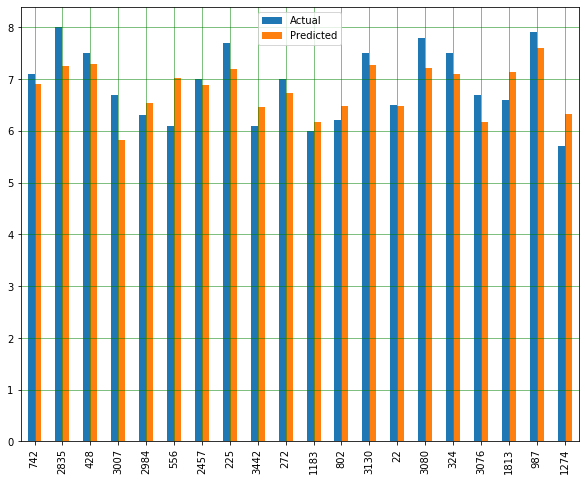

In [58]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [59]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.4563618449603169
Mean Squared Error: 0.34969546074293284
Root Mean Squared Error: 0.5913505396488049


#### Regression Tree

In [60]:
regr_2 = DecisionTreeRegressor(max_depth=5)
reg_tree=regr_2.fit(x_train, y_train)

In [61]:
# Predict
y_2 = regr_2.predict(x_test)
y_2

array([6.82405063, 7.40833333, 7.0888412 , 5.9626087 , 6.51801802,
       7.0888412 , 7.04086957, 7.40833333, 6.51801802, 6.916     ,
       6.18023256, 5.9375    , 7.40833333, 6.828125  , 7.40833333,
       7.04086957, 6.18023256, 7.0888412 , 8.01081081, 6.27514124,
       5.9626087 , 8.00212766, 7.40833333, 6.82405063, 5.9626087 ,
       6.18023256, 5.9626087 , 6.5275    , 8.03448276, 5.37692308,
       5.9626087 , 8.01081081, 7.40833333, 7.40833333, 7.40833333,
       5.37692308, 5.37692308, 7.7       , 3.0375    , 7.1972973 ,
       7.04086957, 5.9626087 , 5.37692308, 7.0888412 , 6.5275    ,
       5.37692308, 6.51801802, 5.9626087 , 6.27514124, 5.44035088,
       7.52241379, 8.01081081, 6.27514124, 6.03333333, 7.0888412 ,
       5.37692308, 7.61908397, 6.27514124, 5.37692308, 6.828125  ,
       7.40833333, 7.40833333, 5.37692308, 6.18023256, 7.61908397,
       7.1972973 , 7.38695652, 6.18023256, 7.04086957, 7.52241379,
       6.27514124, 7.40833333, 7.40833333, 6.5275    , 4.95   

In [62]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_2})
df3 = df.head(20)
df3

,Actual,Predicted
742,7.1,6.906515
2835,8.0,7.245835
428,7.5,7.284904
3007,6.7,5.827050
2984,6.3,6.540352
556,6.1,7.018600
2457,7.0,6.882821
225,7.7,7.199053
3442,6.1,6.450525
272,7.0,6.724702


In [63]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_2))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_2)))

Mean Absolute Error: 0.46860234918194243
Mean Squared Error: 0.37736984706832755
Root Mean Squared Error: 0.6143043602875756


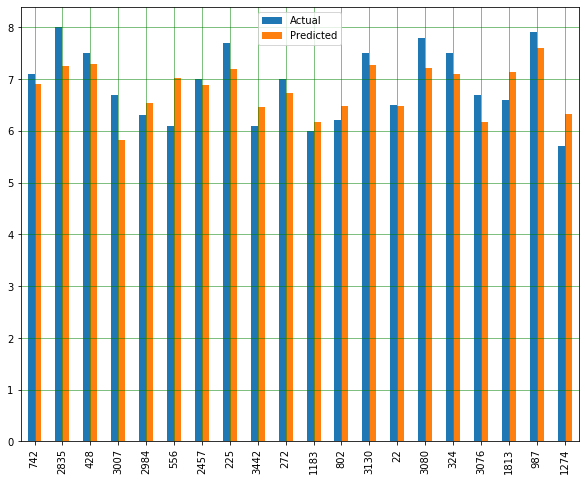

In [64]:
df3.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### Random Forest

In [65]:
model = RandomForestRegressor()
model.fit(x_train,y_train)

# Get the mean absolute error on the validation data
predicted_ratings = model.predict(x_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [66]:
df7 = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_ratings})
df8 = df3.head(20)
df8

,Actual,Predicted
742,7.1,6.906515
2835,8.0,7.245835
428,7.5,7.284904
3007,6.7,5.827050
2984,6.3,6.540352
556,6.1,7.018600
2457,7.0,6.882821
225,7.7,7.199053
3442,6.1,6.450525
272,7.0,6.724702


In [67]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predicted_ratings))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predicted_ratings))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted_ratings)))

Mean Absolute Error: 0.4585714285714286
Mean Squared Error: 0.3585425170068027
Root Mean Squared Error: 0.5987841990290014


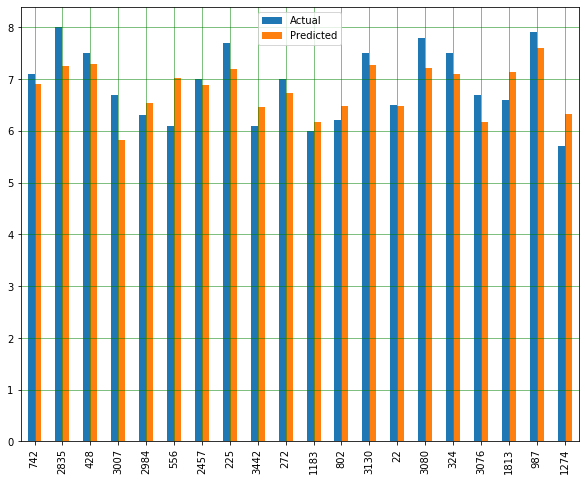

In [68]:
df8.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### Neural Network

In [79]:
x_train# first neural network with keras tutorial

y=movies_ratings.rating
x=movies_ratings.drop('rating',axis=1)

# fit the keras model on the dataset
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = 109, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))


# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()
NN_model.fit(x_train, y_train, epochs=200, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               14080     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [70]:
y_test = y_test.to_frame()

In [71]:
y_test = y_test.reset_index()

In [80]:
#Predict
y_4 = NN_model.predict(x_test).tolist()
y_4 = pd.Series(y_4)
type(y_4)

pandas.core.series.Series

In [81]:
y_4=pd.DataFrame.from_items(zip(y_4.index,y_4.values))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


In [82]:
y_4=y_4.transpose()

In [75]:
#pd.DataFrame(y_4).to_numpy

In [83]:
df5 = pd.DataFrame({'Actual': y_test['rating'], 'Predicted': y_4[0]})
df6=df5.head(20)
df6

,Actual,Predicted
0,7.1,6.815780
1,8.0,6.815780
2,7.5,6.815780
3,6.7,6.815780
4,6.3,6.815780
5,6.1,6.815780
6,7.0,6.815780
7,7.7,6.815780
8,6.1,6.760609
9,7.0,6.815780


In [84]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test['rating'], y_4[0]))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test['rating'], y_4[0]))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test['rating'], y_4[0])))

Mean Absolute Error: 0.7417412736788898
Mean Squared Error: 0.8877306256962635
Root Mean Squared Error: 0.9421945795302918


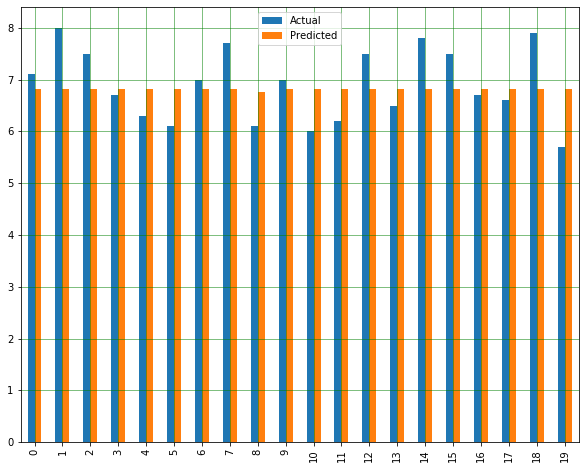

In [85]:
df6.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Conclusion

After using different models to predict the movies' ratings, using MSE as a score metric to evaluate models:
- Order of model fit: Linear Regression > Random Forest > Regression Tree > Neural Net